In [99]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
from matplotlib.pylab import rcParams
%matplotlib inline

# 3.0 Precipitation Day Count Modelling
What I think is more interesting than describing how precipitation levels are changing over time is describing how the observed number of rainy days in a week is changing over time.  Why, you ask?  Well I may not necessarily care _how much_ rain we're supposed to get on any particular day of this week or next week but rather _how many days_ will it rain.  Imagine Thursday rolls around and we've experienced 4/4 days of rain so far, I might want to ask:

  * What are the chances that Friday is going to be yet another day with precipitation?
  * What are the chances that it will rain on some combination of Friday, Saturday, or Sunday?
  * What are the chances that Thursday is the last day with observed precipitation this week?

One can of course refer to the weather network's 14 day forecast (like the one shown below) and either count the number of days with expected precipitation > 0mm, count the number of days with POP > 50%, or compute an expected value which is a function of the previous two measures but these simple methods will likely lead to inaccurate results (something we will test [TODO]).

<img src ="../../images/ldn_on_forecast_2017-07-29.png" style="height: 400px;" />

The structure of this analysis is as follows:

  1. Transform the original weather dataset into a form that contains only precipitation and rainfall measurements
  2. Create a dataset containing weekly counts of rainy days using both rain and precipitation observations
  3. Visualize the distributions of weekly rain day counts accross time


In the next notebook, we'll develop a stochastic model that estimates current and next-week precipitation day counts, comparing the forecasts to methods applied to the Weather Network's [forecasted precipitation levels](https://www.theweathernetwork.com/ca/14-day-weather-trend/ontario/london).

It is not necessarily the case that more observed rain days equates to an increase in rain levels but this is what one would expect.  Later in this notebook, we'll quantitatevly describe the corrleation between number of weekly precipitation days and weekly precipitation total [TODO].

## 3.1 Data Prep

The data used in this analysis was created in the [introduction notebook](#).  It includes daily aggregated weather and precipitiation observations (measurements) from three weather stations in London, Ontario since 2010.  The [exploratory notebook](#) visualized relationships between weather and precipitation observations and identified the fact that rainfall data is systematically missing for the months of April through October.  With such a substantial amount of missing data, we can use the more reliable precipitation observations to identify rainfall in the spring, summer, and early fall months.  While precipitation can take on several forms including drizzle, rain, sleet, snow, graupel, and hail, it is a reasonable assumption that any observed precipitation in April through October will be observations of rain if the observed value is more than 0.2mm (see [[1]](http://wiki.sandaysoft.com/a/Rain_measurement) and [[2]](https://ec.gc.ca/meteo-weather/default.asp?lang=En&n=B8CD636F-1&def=show02B55773D#wsDT2B55773D)).

#### Load

In [26]:
# Load and describe variables
df = pd.read_csv("../../data/notebook1_weather_by_day_2017-07-21.csv", parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 12 columns):
date                  2759 non-null datetime64[ns]
maxTemp               2758 non-null float64
minTemp               2759 non-null float64
meanTemp              2758 non-null float64
heatDegDays           2758 non-null float64
coolDegDays           2758 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2720 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1953 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 258.7 KB


#### Transform

In [27]:
# Seasons
def season(date):
  if date.month == 12 or date.month < 3:
    # December - Feb
    return 'winter'
  elif date.month >= 3 and date.month < 6:
    # March - June
    return 'spring'
  elif date.month >= 6 and date.month < 9:
    # June - Sept
    return 'summer'
  else:
    # Sept - Nov
    return 'fall'

# Date components
df['month'] = df.date.apply(lambda x: x.month)
df['year']  = df.date.apply(lambda x: x.year)
df['season'] = pd.Series(df.date).apply(season).values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 15 columns):
date                  2759 non-null datetime64[ns]
maxTemp               2758 non-null float64
minTemp               2759 non-null float64
meanTemp              2758 non-null float64
heatDegDays           2758 non-null float64
coolDegDays           2758 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2720 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1953 non-null float64
month                 2759 non-null int64
year                  2759 non-null int64
season                2759 non-null object
dtypes: datetime64[ns](1), float64(11), int64(2), object(1)
memory usage: 323.4+ KB


In [28]:
precip_df = df[['date', 'month', 'year', 'season', 'totalPrecipMM', 'totalRainMM']]
precip_df.head()

,date,month,year,season,totalPrecipMM,totalRainMM
0,2010-01-01,1,2010,winter,4.9,0.0
1,2010-01-02,1,2010,winter,4.1,0.0
2,2010-01-03,1,2010,winter,1.1,0.0
3,2010-01-04,1,2010,winter,0.5,0.0
4,2010-01-05,1,2010,winter,0.0,0.0


`precip_df` is daily panel data from a sensor that measures rainfall and precipitation.  As noted above, precipitation is considered to be rain if it is not drizzle, sleet, snow, graupel, or hail, and is observed at a level of $\ge0.2mm$.

In [29]:
precip_df.query("totalRainMM > 0").totalPrecipMM.describe()

count    304.000000
mean       6.575329
std        7.100813
min        0.100000
25%        1.487500
50%        4.050000
75%        9.712500
max       47.300000
Name: totalPrecipMM, dtype: float64

The minimum precipitation level that constitutes rain in this dataset is 0.1mm so we'll use that as our criteria going forward.

In [30]:
# Describe rainfall values for months with missing rain measurements
missing_rain = (precip_df.month.isin(list(range(4,11)))) & (precip_df.totalRainMM.isnull())
precip_df.loc[missing_rain, 'totalRainMM'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: totalRainMM, dtype: float64

In [31]:
# Replace `totalRainMM` measurements with precipitation for `totalPrecipMM` >= 0.1
rain_df = precip_df.copy()
rain_df.loc[missing_rain, 'totalRainMM'] = rain_df.loc[missing_rain, 'totalPrecipMM'].apply(
  lambda x: x if x >= 0.1 else 0)
rain_df.head()

,date,month,year,season,totalPrecipMM,totalRainMM
0,2010-01-01,1,2010,winter,4.9,0.0
1,2010-01-02,1,2010,winter,4.1,0.0
2,2010-01-03,1,2010,winter,1.1,0.0
3,2010-01-04,1,2010,winter,0.5,0.0
4,2010-01-05,1,2010,winter,0.0,0.0


In [32]:
rain_df[missing_rain].totalRainMM.describe()

count    1506.000000
mean        2.922510
std         7.100803
min         0.000000
25%         0.000000
50%         0.000000
75%         2.075000
max        69.700000
Name: totalRainMM, dtype: float64

Set the index to the date for time series visualizations.

In [33]:
rain_df.set_index("date", drop=True, inplace=True)

## 3.2 Rainfall Analysis

Since we hadn't formally defined rain days in the previous notebook as we've done here, we'll take a closer look at the rainfall data statistics and how they have changed over time

In [34]:
rain_stats = rain_df.totalRainMM.describe()
rain_stats

count    2714.000000
mean        2.327450
std         6.118115
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        69.700000
Name: totalRainMM, dtype: float64

In [35]:
rain_df.totalRainMM.quantile(np.linspace(0.6, 0.75, 10))

0.600000    0.0
0.616667    0.0
0.633333    0.0
0.650000    0.0
0.666667    0.0
0.683333    0.2
0.700000    0.3
0.716667    0.6
0.733333    0.8
0.750000    1.0
Name: totalRainMM, dtype: float64

Approximately 66-67% of the data include days with observed rain.  The **average** amount of observed rain (in millimeters) is {{"{:.2f}".format(rain_stats['mean'])}} with a **standard deviation** of {{"{:.2f}".format(rain_stats['std'])}}.  This means that, on average, we **expect {{"{:.2f}".format(rain_stats['mean'])}}mm of rain +/- {{"{:.2f}".format(rain_stats['std'])}}mm**.  The **maximum** observed rain was {{"{:.2f}".format(rain_stats['max'])}}mm on {{str(rain_df[rain_df.totalRainMM == rain_df.totalRainMM.max()].index[0].date())}}.

### Yearly and monthly rainfall

Since data is not complete for the year, visualize year to day (YTD) values.

In [36]:
now = datetime.now().month
rain_df_ytd = rain_df[rain_df.month <= now]

#### Total rainfall

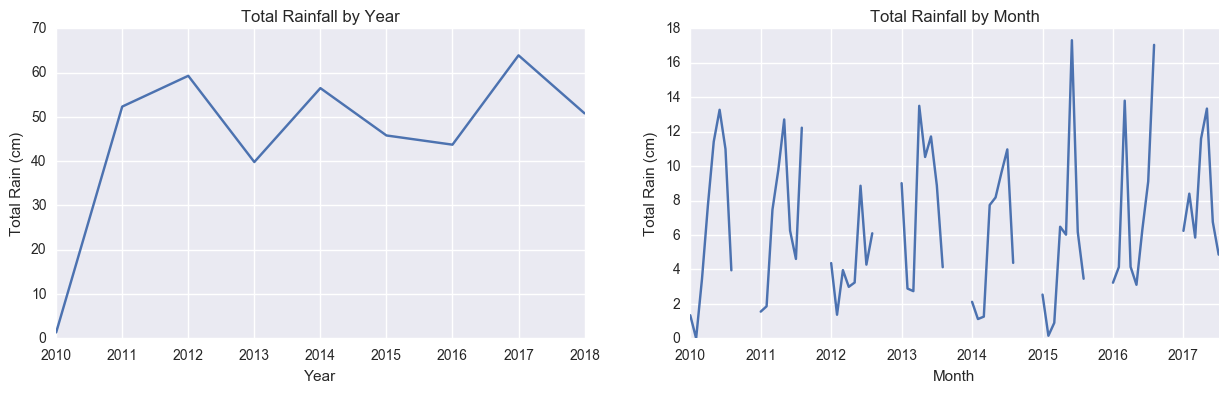

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
_ = (rain_df_ytd.totalRainMM.resample('12M').sum() / 10).plot(ax=ax1)
_.set_title("Total Rainfall by Year")
_.set_ylabel("Total Rain (cm)")
_.set_xlabel("Year")
_ = (rain_df_ytd.totalRainMM.resample('1M').sum() / 10).plot(ax=ax2);
_.set_title("Total Rainfall by Month")
_.set_ylabel("Total Rain (cm)")
_.set_xlabel("Month");

#### Average rainfall

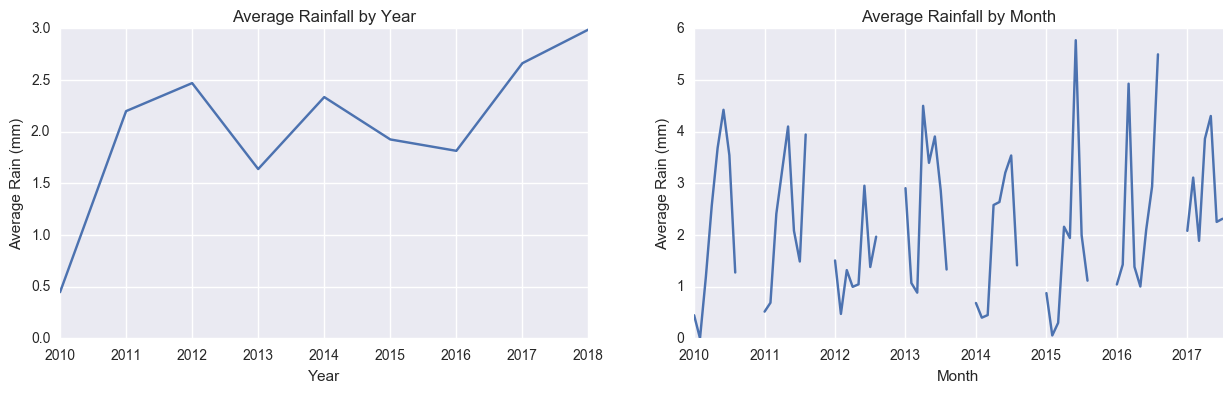

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
_ = rain_df_ytd.totalRainMM.resample('12M').mean().plot(ax=ax1)
_.set_title("Average Rainfall by Year")
_.set_ylabel("Average Rain (mm)")
_.set_xlabel("Year")
_ = rain_df_ytd.totalRainMM.resample('1M').mean().plot(ax=ax2);
_.set_title("Average Rainfall by Month")
_.set_ylabel("Average Rain (mm)")
_.set_xlabel("Month");

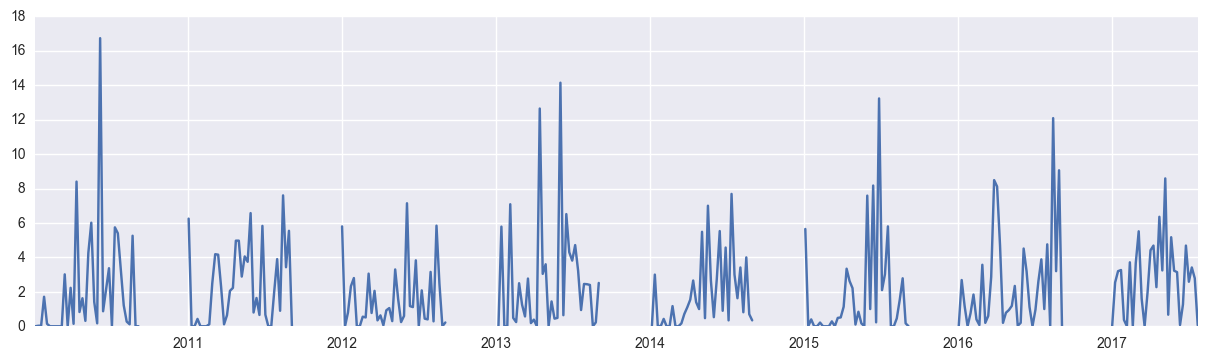

In [60]:
plt.figure(figsize=(15,4))
plt.plot(rain_df_ytd.totalRainMM.resample("1W").mean());

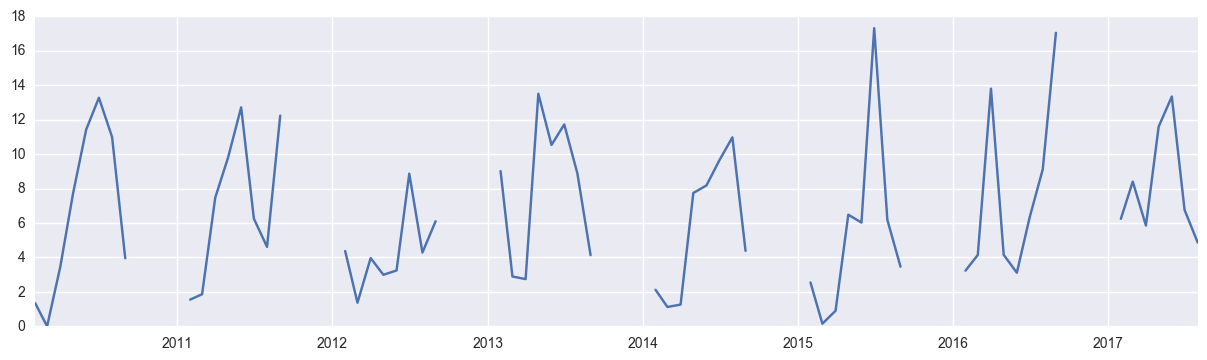

In [56]:
plt.figure(figsize=(15,4))
plt.plot(rain_df_ytd.totalRainMM.resample("1M").sum() / 10);

There was much higher rainfall as seen by the weekly YTD time series.  Observe considerably higher spikes towards the end of the 2016 time series compared to 2017.  It was mentioned earlier that an increase or decrease in total rainfall does not necessarily imply an increase or decrease in the average number of rainy days in a week.

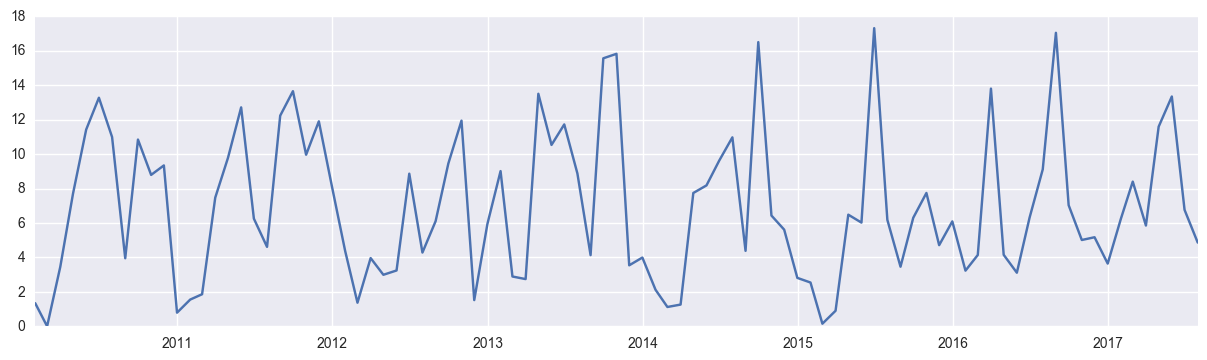

In [62]:
plt.figure(figsize=(15,4))
plt.plot(rain_df.totalRainMM.resample("1M").sum() / 10);

The final graph shows some seasonality with high year over year variability with increasing trend.

## 3.3 Weekly Rain Day Count Modelling

### Create a count dataset describing the number of rainy days per week

In [65]:
rain_df.head()

,month,year,season,totalPrecipMM,totalRainMM
date,,,,,
2010-01-01,1,2010,winter,4.9,0.0
2010-01-02,1,2010,winter,4.1,0.0
2010-01-03,1,2010,winter,1.1,0.0
2010-01-04,1,2010,winter,0.5,0.0
2010-01-05,1,2010,winter,0.0,0.0


In [66]:
rain_days = rain_df.reset_index()[
  ['date', 'totalRainMM']
].set_index('date').resample('1W').apply(
    # Count the number of non-zero rain days
    lambda x: np.count_nonzero(x)).astype(int).rename(
  columns={'totalRainMM': 'weeklyRainDayCount'})
rain_days.head()

,weeklyRainDayCount
date,
2010-01-03,0
2010-01-10,1
2010-01-17,2
2010-01-24,2
2010-01-31,1


Apply transformations

In [67]:
rain_days['month'] = pd.Series(rain_days.index).apply(lambda x: x.month).values
rain_days['year'] = pd.Series(rain_days.index).apply(lambda x: x.year).values
rain_days['season'] = pd.Series(rain_days.index).apply(season).values
rain_days.head(1)

,weeklyRainDayCount,month,year,season
date,,,,
2010-01-03,0,1,2010,winter


### Distribution of `weeklyRainDays`

In [71]:
rain_day_stats = rain_days.weeklyRainDayCount.describe().round(2)
rain_day_stats

count    395.00
mean       2.36
std        1.61
min        0.00
25%        1.00
50%        2.00
75%        3.00
max        7.00
Name: weeklyRainDayCount, dtype: float64

**Average** number of rain days in a week is {{"{:.2f}".format(rain_day_stats['mean'])}} with a **standard deviation** of {{"{:.2f}".format(rain_day_stats['std'])}}.  In other words, it's far from unlikely that we'll see up to 7 days of rain within a week.  This in itself is not very helpful and we're failing to capture any seasonal effects - we could get a more accurate values if we condition on the month or season of the observation.

#### Estimate standard error of the mean

count    10000.000000
mean         2.359560
std          0.080563
min          2.032911
25%          2.306329
50%          2.359494
75%          2.412658
max          2.630380
dtype: float64


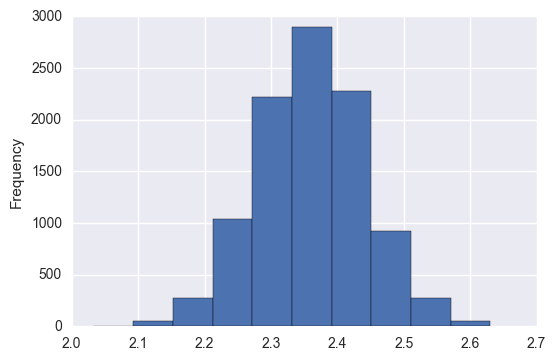

In [128]:
def bootstrap(s, reps=10000):
  reps = reps
  xb = np.random.choice(s, (len(s), reps), replace=True)
  # Take the mean accross rows
  bs = pd.Series(xb.mean(axis=0))
  return bs
bs = bootstrap(rain_days.weeklyRainDayCount)
bs.plot(kind='hist');
print(bs.describe())

In [98]:
bs.describe()['mean'] - bs.describe()['std'] * 1.96, bs.describe()['mean'] + bs.describe()['std'] * 1.96

(2.2026163222583182, 2.5176120321720616)

95% confidence interval for the mean.  In other words, the expected or mean value of rain days in a week is ~2 days.  That is, on average, we would expect 2 days of rain per week.

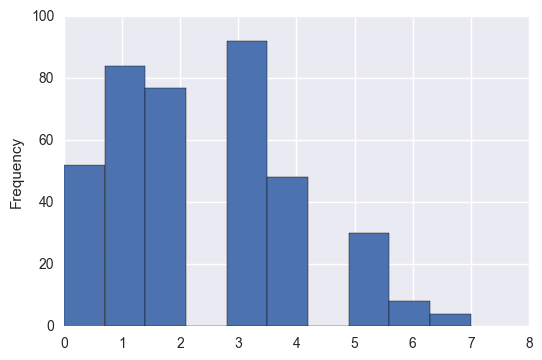

In [80]:
rain_days.weeklyRainDayCount.astype(int).plot(kind='hist')

A likely candidate distribution for the count is the Poisson distribution with $\lambda=\mu_R$ where $\mu_R$ is the mean or average of the `weeklyRainDayCount`.  Use the bootstrapped to generate a count (Poisson) distribution.

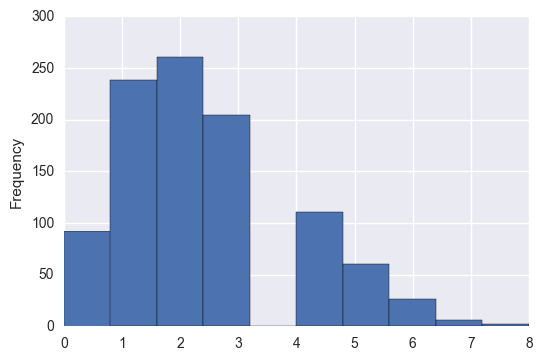

In [168]:
sim = pd.Series(stats.poisson.rvs(bs.mean(), size=1000))
sim.plot(kind='hist')

### Seasonal Distribution of `weeklyRainDays`

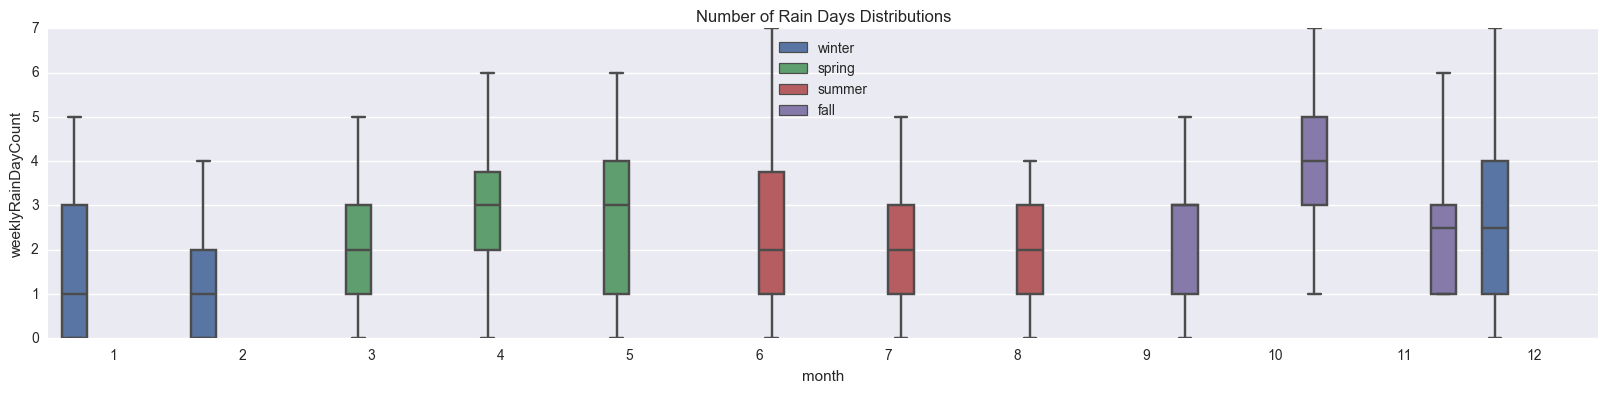

In [174]:
plt.figure(figsize=(20,4))
_ = sns.boxplot(x="month", y="weeklyRainDayCount", data=rain_days, hue="season");
_.set_title("Number of Rain Days Distributions")
plt.legend(loc='best');

Seasonal effects are evident as the number of rain days drops is higher in fall and winter.  Within-group variability appears to be lower in spring and summer months and fall and winter are periodic.  June has the greatest observed variance though from this graphic, we cannot tell how rare the outliers are or when they occured.

#### Seasonal rain day count distributions

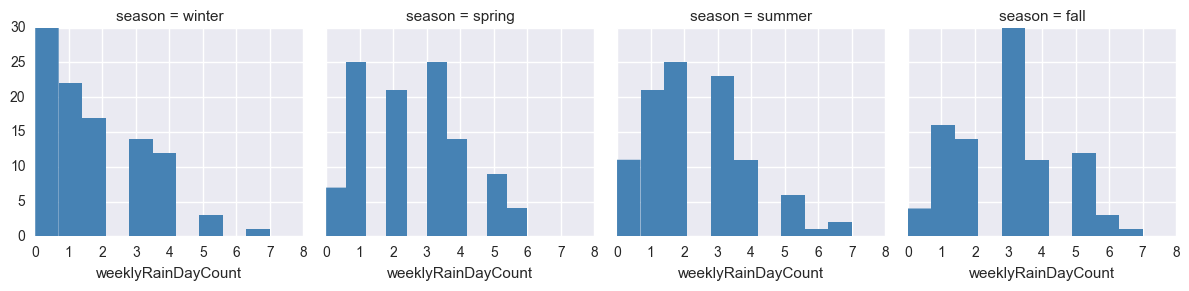

In [176]:
g = sns.FacetGrid(rain_days, col="season", margin_titles=True)
g.map(plt.hist, "weeklyRainDayCount", color="steelblue", lw=0);

In [180]:
rain_days.groupby("season").describe().weeklyRainDayCount

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
fall,91.0,2.890110,1.545248,0.0,2.0,3.0,4.0,7.0
spring,105.0,2.542857,1.544398,0.0,1.0,2.0,4.0,6.0
summer,100.0,2.340000,1.558424,0.0,1.0,2.0,3.0,7.0
winter,99.0,1.696970,1.587287,0.0,0.0,1.0,3.0,7.0


Spring and summer months tend to have higher precipitation, as expected.

### Rain day counts over time

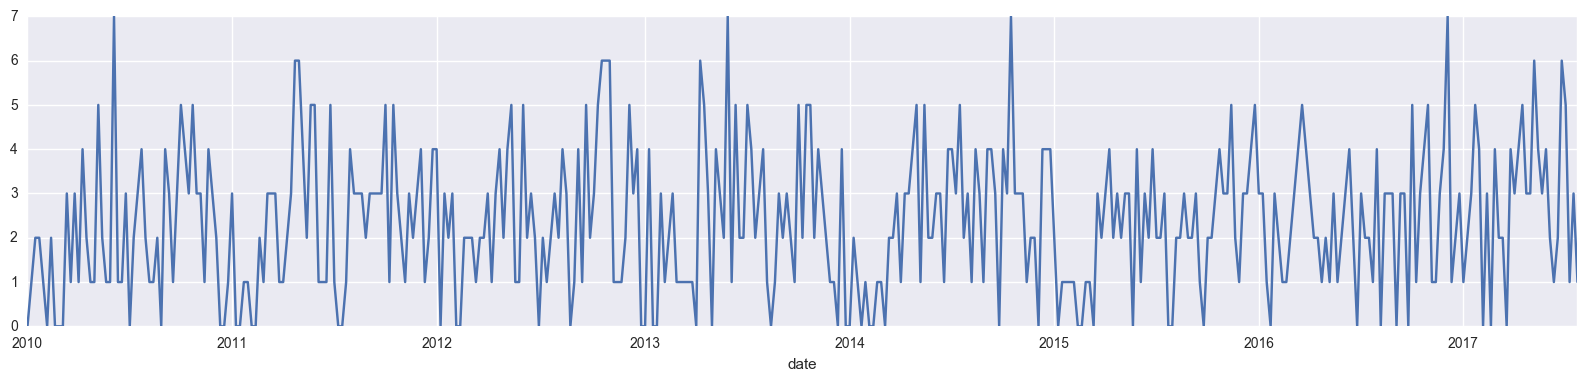

In [190]:
fig = plt.figure(figsize=(20,4))
rain_days.weeklyRainDayCount.plot();

It's hard to discern any seasonality but there defffinitely looks to be inear growth from mid-2016 to the beginning of August.  It also looks like 2017 has experienced the highest level (average) number number of average weekly rain days.

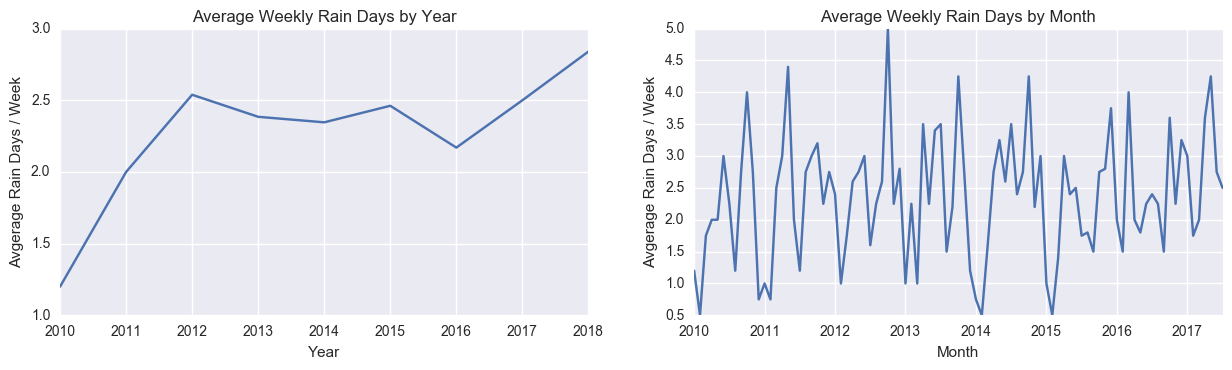

In [196]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3.7))
_ = rain_days.weeklyRainDayCount.resample('12M').mean().plot(ax=ax1)
_.set_title("Average Weekly Rain Days by Year")
_.set_ylabel("Avgerage Rain Days / Week")
_.set_xlabel("Year")
_ = rain_days.weeklyRainDayCount.resample('1M').mean().plot(ax=ax2);
_.set_title("Average Weekly Rain Days by Month")
_.set_ylabel("Avgerage Rain Days / Week")
_.set_xlabel("Month");

### Rain day counts by year

Plot rain days by year, year to day, to see how much things have changed this year (if at all)

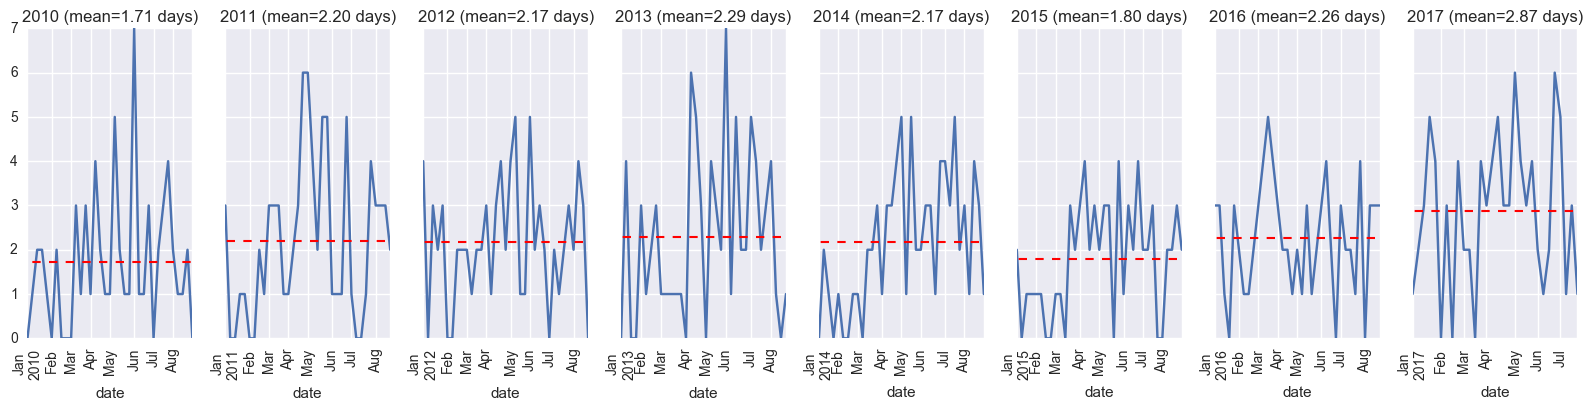

In [198]:
fig, ax = plt.subplots(1, 8, sharey=True, figsize=(20,4))
month = datetime.today().month
for i, y in enumerate(range(2010, 2018)):
  d = rain_days.query("(year == {}) & (month <= {})".format(y, month)).weeklyRainDayCount
  _ = d.plot(ax=ax[i], rot=90)
  _.axhline(y=d.mean(), xmin=-1, xmax=1, c="red", linewidth=1.5, linestyle="--")
  _.set_title("{} (mean={:.2f} days)".format(y, d.mean()))

We can calculate the year-to-year changes in both nominal and percentage terms

In [ ]:
days_mean = rain_days.query("(month <= {})".format(month)).groupby('year').weeklyRainDayCount.mean()

#### Year over year percent changes

In [228]:
changes = ((days_mean - days_mean.shift()) / days_mean.shift()).dropna()

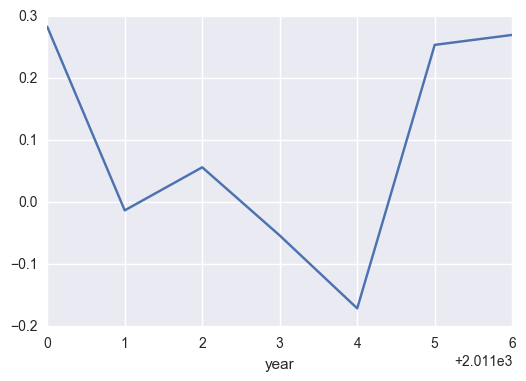

In [230]:
changes.plot();

#### Year over year nominal changes

In [234]:
changes = (days_mean - days_mean.shift()).dropna()
changes

year
2011    0.485714
2012   -0.028571
2013    0.122689
2014   -0.122689
2015   -0.371429
2016    0.457143
2017    0.609524
Name: weeklyRainDayCount, dtype: float64

Note how the average never changes by more than a day.  It may be more useful to explore long-run sequences

From these graphs, it's evident that we've had more higher-than-average rain day counts this year than in previous years.  Notable deviations from historical rain day count observations include frequent spikes at 6 days.  From these graphs we can also see that a full seven days of rain is rare

In [ ]:
print("Frequency of seven day rain counts: {:.2f}".format(
    len(rain_days.query("weeklyRainDays == 7")) * 1.0 / len(rain_days)))

### Monthly rain day count distributions by year/month
Plot the histograms (counts) of observed weekly rain day counts for each month/year combination

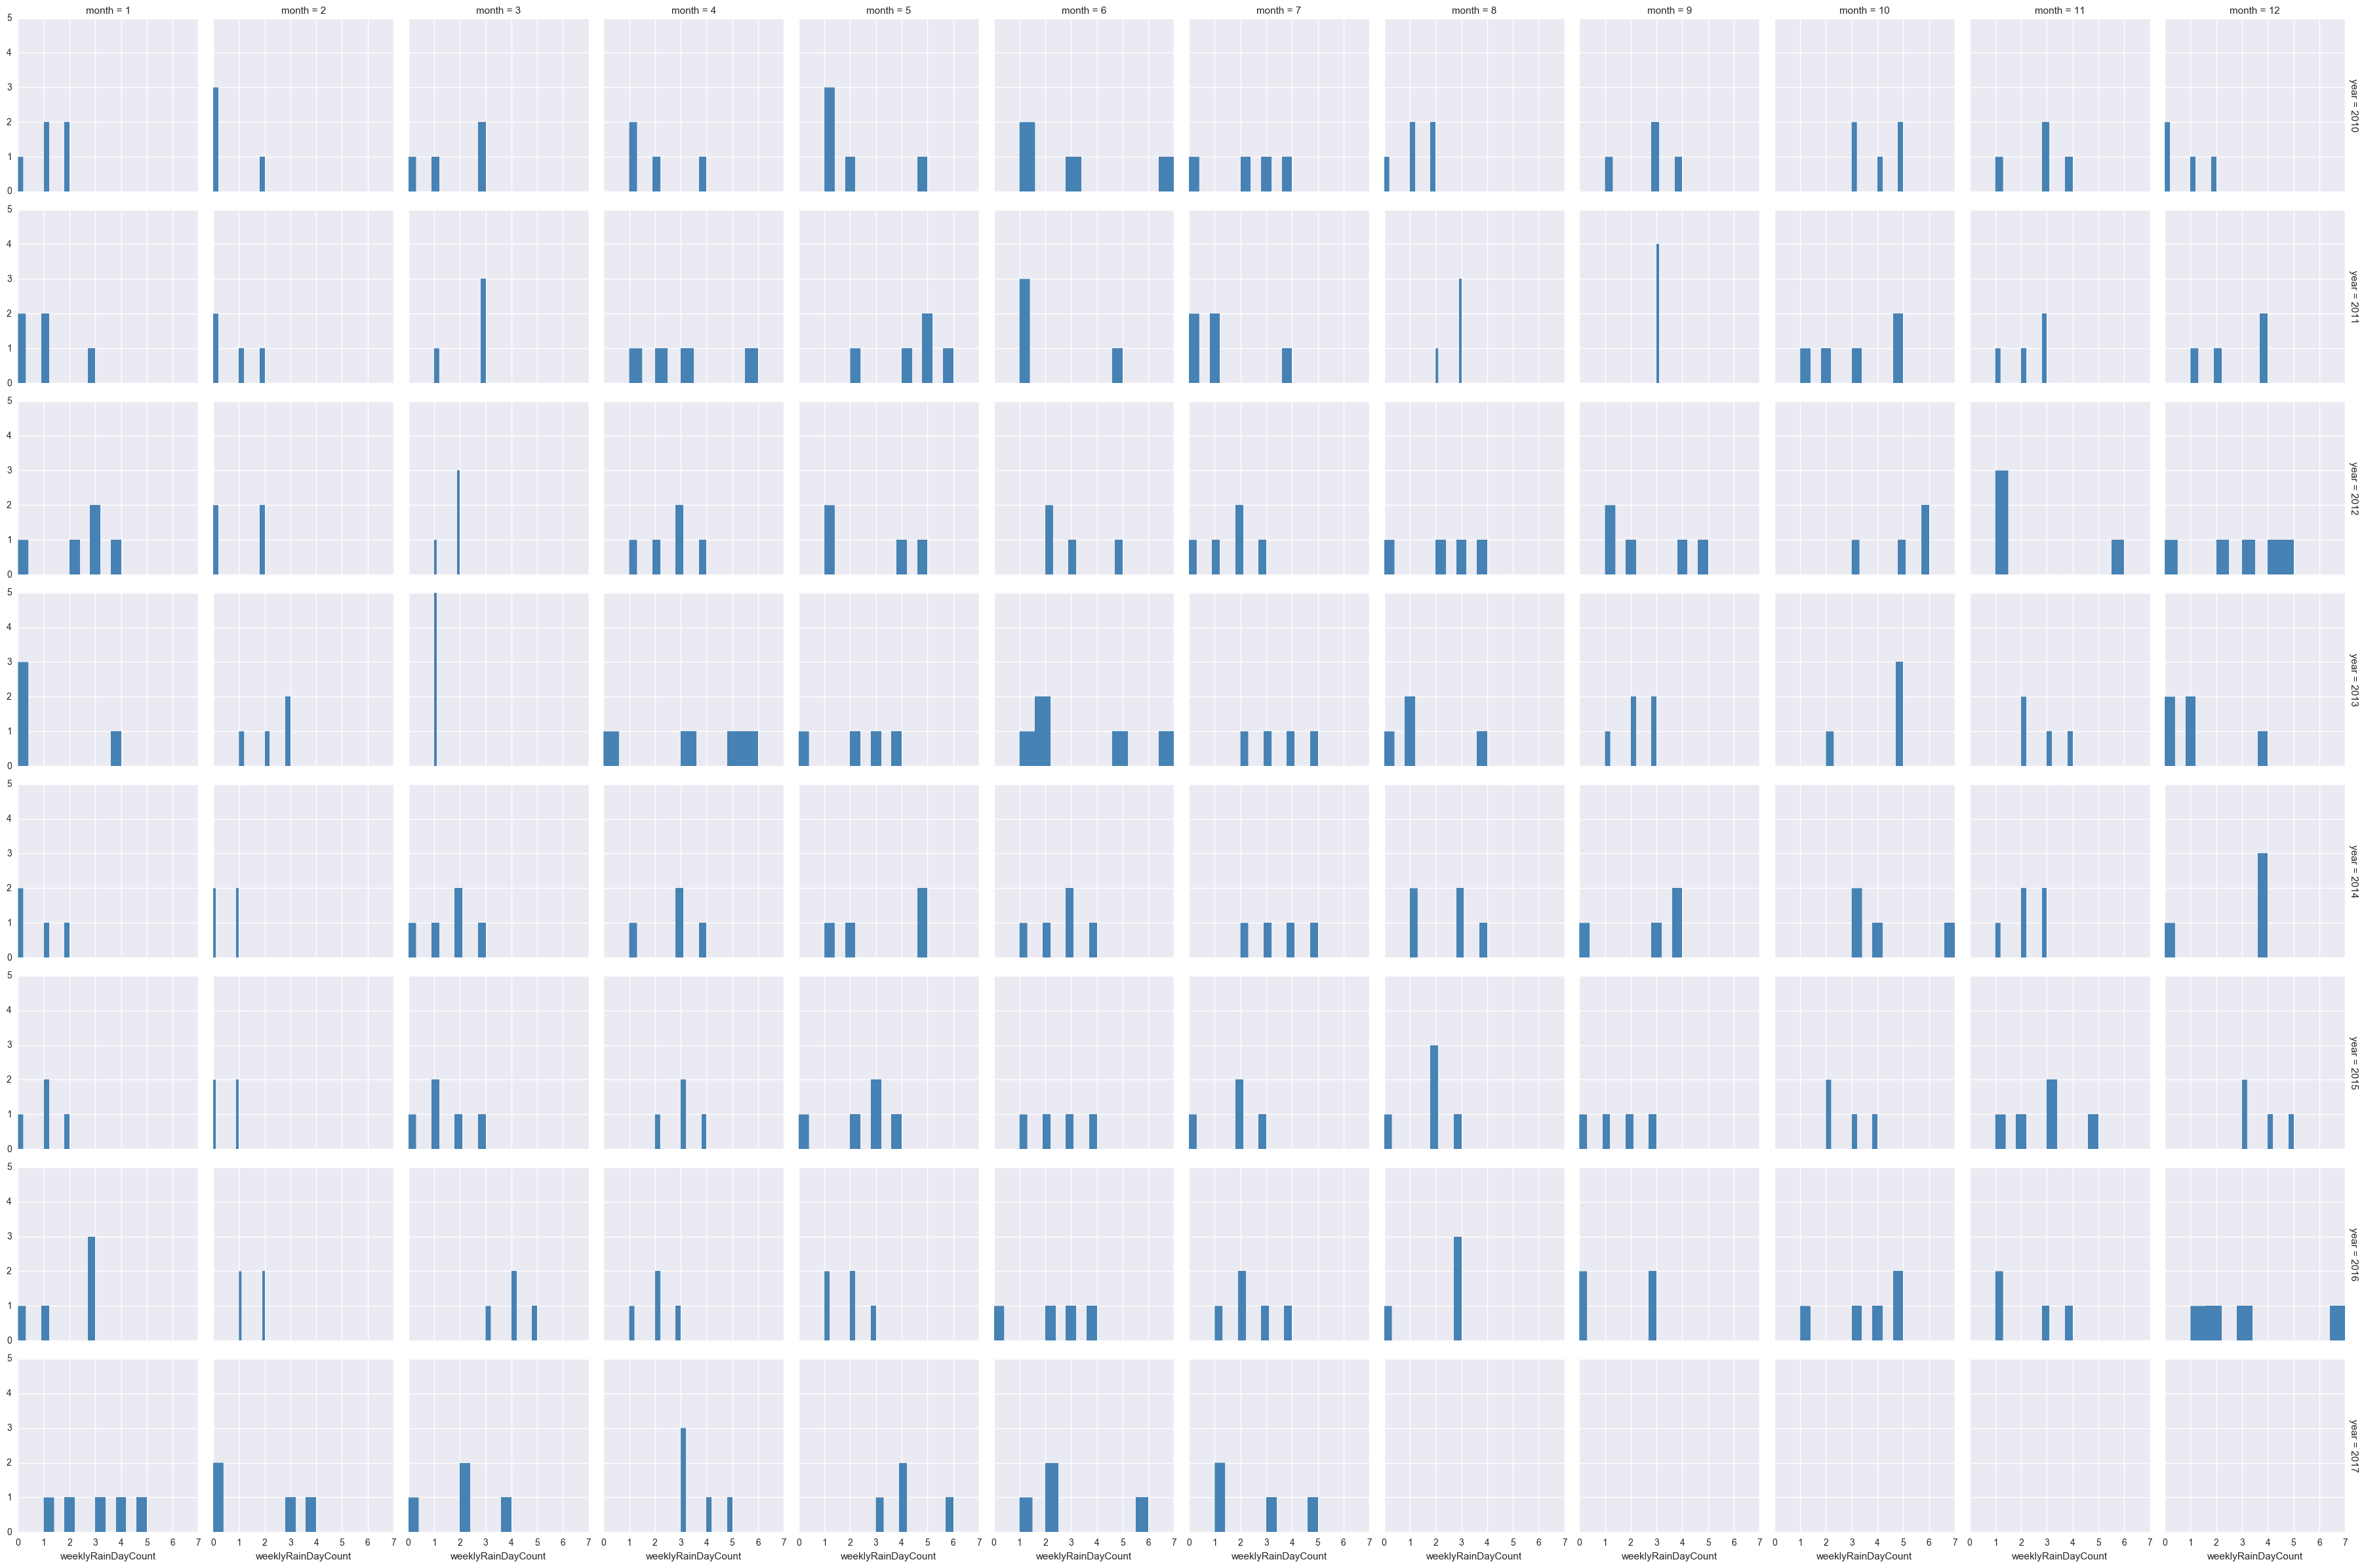

In [227]:
g = sns.FacetGrid(rain_days, row="year", col="month", margin_titles=True)
g.map(plt.hist, "weeklyRainDayCount", color="steelblue", lw=0);

Looking at the graph above, for any particular month, row by row, describes the year-to-year change in probability of observing 1-7 days of precipitation i.e. expected value of weekly rain days.  Focusing on the bottom two rows allow for a better comparison of monthly rain day distribution changes.  That is, how much more likely observed rain day counts are becoming.

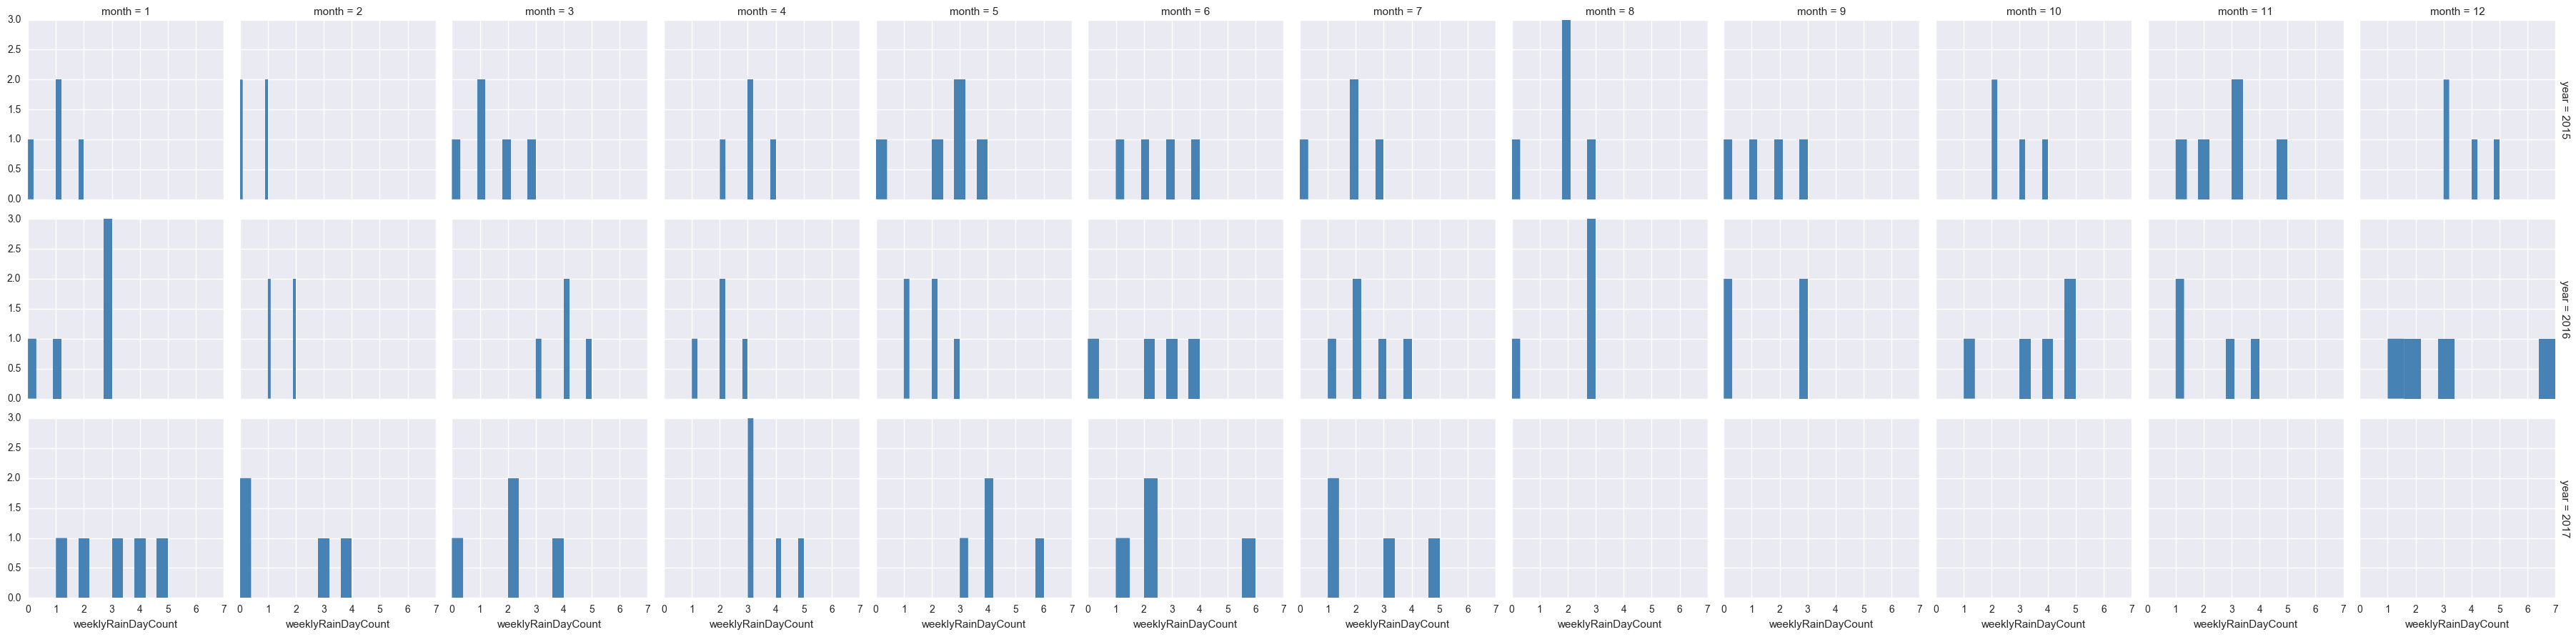

In [237]:
g = sns.FacetGrid(rain_days[rain_days.year.isin([2015, 2016, 2017])], row="year", col="month", margin_titles=True)
g.map(plt.hist, "weeklyRainDayCount", color="steelblue", lw=0);

CSV

In [ ]:
rain_days.to_csv("../../data/rain_days_2017-08-01.csv", index=True)